### Objectives

First, create a graph representation of the information we have. 
This would be information about the elements, and the nodes. 
Using this, we will feed it into our SVM, or a Random Forest, and see from there onwards

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


In [17]:
n = pd.read_csv('./full_node_Table_.csv')
df = pd.read_csv('./full_Table_.csv')

In [18]:
cc_df = df.sample(n=10000, random_state=1)
cc_df['cc_pixel_intensity_488'] = cc_df['cc_pixel_intensity_488'].astype(int)

X = cc_df.drop(['cc_pixel_intensity_488', 'cc_pixel_intensity_405', 'cc_x', 'folder_name_x', 'degree_distribution', 'folder_name_x.1', 'folder_name_y', 'x_y', 'y_y', 'z_y', 'node', 'degree', 'cc_y', 'vol_cc', 'avg_PK_Of_element', 'element_connectivity', 'cc_average_connectivity'], axis=1)  # Adjust 'target_column' to your actual target column name
# Print rows that have NaN in any column, and print that column name
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

# For any rows that contain a NaN in X, drop it in X and drop the corresponding row in Y.
# This is done by getting the row index where X is NaN and dropping the same index in both X and Y
nan_rows = X.isna().any(axis=1)
X = X.dropna()

y = cc_df['cc_pixel_intensity_488']
y = y[~nan_rows]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.to_numpy()

y_test=y_test.to_numpy()

In [19]:
def plot_error_frequency(y_pred, y_test, classifier_title):
    # Calculate errors
    errors = y_pred != y_test

    # Extract labels where errors occurred
    error_labels = y_test[errors]

    # Calculate frequency of each label
    unique_labels, counts = np.unique(error_labels, return_counts=True)

    # Creating a dictionary of label frequencies for errors
    label_error_frequency = dict(zip(unique_labels, counts))

    # Finding the range of all possible labels (from min to max in y_test and y_pred)
    all_labels = np.unique(np.concatenate((y_test, y_pred)))
    min_label = min(all_labels)
    max_label = max(all_labels)

    # Filling in frequencies for labels that did not have errors
    for label in range(min_label, max_label + 1):
        if label not in label_error_frequency:
            label_error_frequency[label] = 0

    # Sorting the dictionary for plotting
    sorted_label_error_frequency = dict(sorted(label_error_frequency.items()))

    xticks = np.arange(min_label, max_label + 1, 50)

    # Plotting the error frequency
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_label_error_frequency.keys(), sorted_label_error_frequency.values())
    plt.xlabel('Prediction')
    plt.ylabel('Error Frequency')
    plt.title('Error Frequency Distribution for ' + str(classifier_title))
    plt.xticks(xticks, rotation='vertical')  # Set x-ticks to show every 50th label and rotate them vertically
    plt.show()

    # Calculating mean and standard deviation of absolute errors
    absolute_errors = np.abs(y_pred - y_test)
    mean_error = np.mean(absolute_errors)
    std_error = np.std(absolute_errors)
    print("The mean error is", mean_error, "and the standard deviation of the errors is", std_error)

    # Plotting absolute error for each label
    plt.figure(figsize=(10, 6))
    for label in all_labels:
        label_errors = absolute_errors[y_test == label]
        plt.bar([label]*len(label_errors), label_errors, color='r')
    plt.xlabel('Prediction')
    plt.ylabel('Absolute Error')
    plt.title('Absolute Error for Each Label in ' + str(classifier_title))
    plt.xticks(xticks, rotation='vertical')
    plt.show()


In [20]:
# For y_train and y_test, round down to nearest 10
# y_train = (np.floor(y_train / 10) * 10).astype(int)
# y_test = (np.floor(y_test / 10) * 10).astype(int)

# Noticed weird behaviour with SVM:
# If y_train and y_test are not rounded down to nearest 10,
# then the training takes LONGER (it just wouldn't finish training on my mac)
# even though it means there are 10 times fewer classifiers to train?
# (also yes, doing that means the output would not be a regression but a classification,
# and outputs would be classified into groups of 10, as in the model would tell you whether the
# functional parameter is between 0-10, 10-20, 20-30, etc.)

# Also it was not possible to get the SVM to train on my MAC for datasets above 10k rows (10k including training and testing split)
# Training just never finished if I tried that, even if I left it running overnight.

# This makes sense though because with more classes (i.e discrete functional parameter values in this case),
# the training time grows quadratically as that many more classifiers need to be trained.

# print(y_train, y_test)

svm_model = SVC(kernel='linear')  # You can choose different kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

print(pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}))

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

plt.plot(y_test, y_pred, 'o')
plt.title('Accuracy: ' + str(accuracy))
plt.xlabel('Actual')
plt.ylabel('Predicted')

y_pred_svm = y_pred



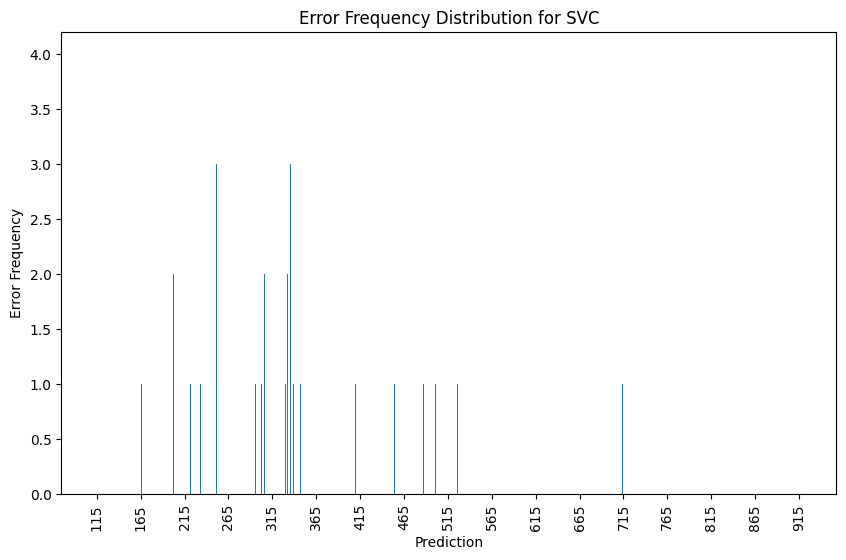

The mean error is 0.973 and the standard deviation of the errors is 8.945125544116193


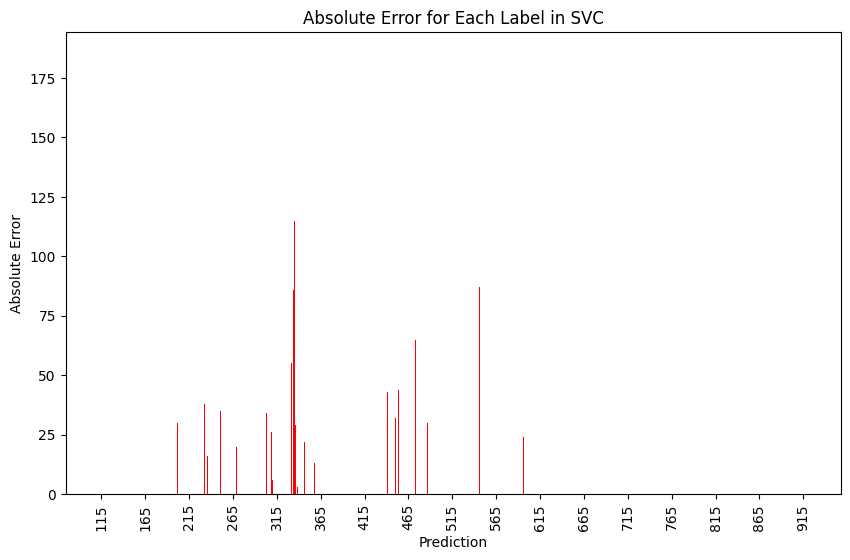

In [ ]:
plot_error_frequency(y_pred_svm, y_test, 'SVC')

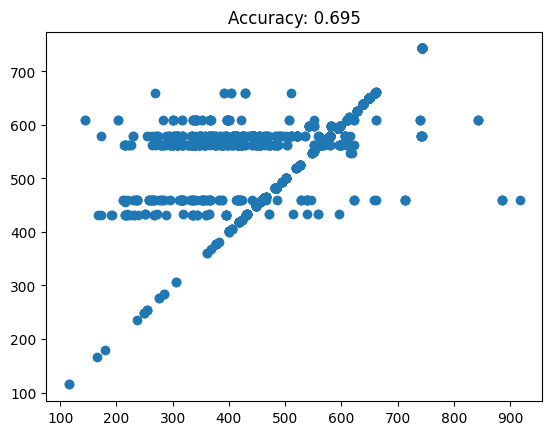

In [ ]:
# do the same for random forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, random_state=0)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

plt.plot(y_test, y_pred, 'o')
plt.title('Accuracy: {}'.format(accuracy))

y_pred_rf = y_pred

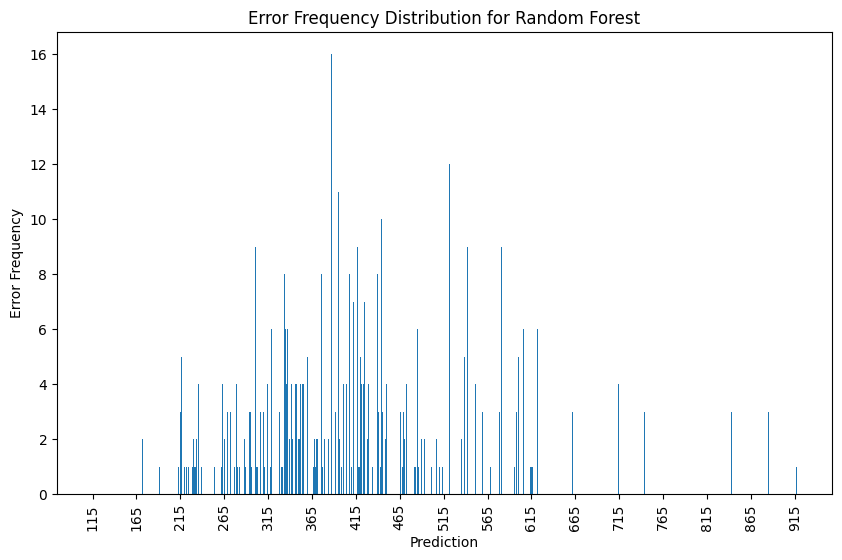

The mean error is 50.3895 and the standard deviation of the errors is 90.36277325176557


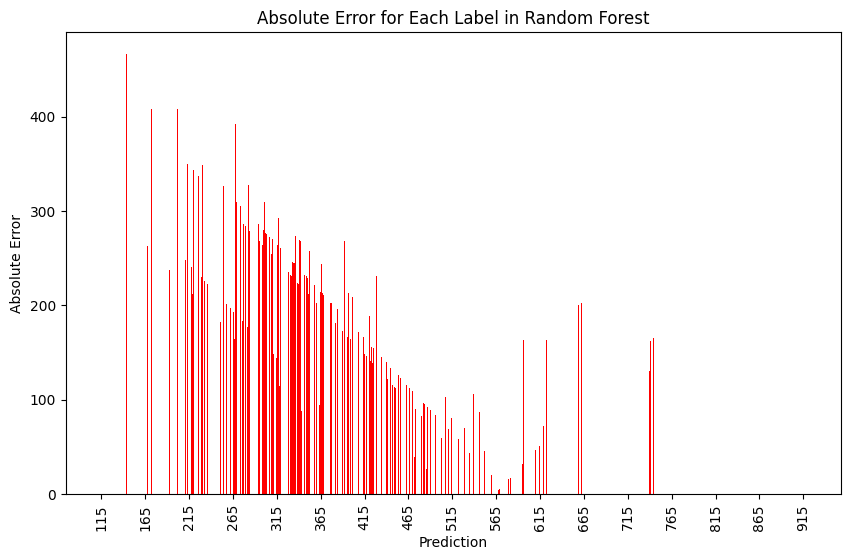

In [ ]:
plot_error_frequency(y_pred_rf, y_test, 'Random Forest')

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Used the plotly library as this is much nicer looking, and the graph is more interactive and works well with Jupyter Notebooks

def plot_absolute_error_plotly(y_pred_svc, y_pred_rf, y_test):
    def calculate_error_frequency(y_pred):
        incorrect = y_pred != y_test

        unique_predictions, counts = np.unique(y_pred[incorrect], return_counts=True)
        error_freq = dict(zip(unique_predictions, counts))

        return error_freq

    error_freq_svc = calculate_error_frequency(y_pred_svc)
    error_freq_rf = calculate_error_frequency(y_pred_rf)

    all_labels = np.unique(np.concatenate((y_pred_svc, y_pred_rf)))
    all_labels.sort()

    svc_freq = [error_freq_svc.get(label, 0) for label in all_labels]
    rf_freq = [error_freq_rf.get(label, 0) for label in all_labels]

    fig = go.Figure(data=[
        go.Bar(name='SVC', x=all_labels, y=svc_freq),
        go.Bar(name='Random Forest', x=all_labels, y=rf_freq)
    ])

    fig.update_layout(
        barmode='group',
        title='Prediction Error Frequency',
        xaxis_title='Predicted Label',
        yaxis_title='Frequency of Incorrect Predictions',
        xaxis=dict(type='category')
    )

    fig.show()


def plot_error_label_frequency_plotly(y_pred_svc, y_pred_rf, y_test):
    labels = np.unique(y_test)
    errors_svc = [np.sum((y_pred_svc != y_test) & (y_test == label)) for label in labels]
    errors_rf = [np.sum((y_pred_rf != y_test) & (y_test == label)) for label in labels]

    bar_width = max(0.5, 30 / len(labels))

    fig = go.Figure(data=[
        go.Bar(name='SVC', x=labels, y=errors_svc, width=bar_width, marker_color='blue', marker_line_color='blue', marker_line_width=1.5, opacity=1),
        go.Bar(name='Random Forest', x=labels, y=errors_rf, width=bar_width, marker_color='red', marker_line_color='red', marker_line_width=1.5, opacity=1)
    ])
    
    fig.update_layout(
        barmode='group',
        title='Error Frequency per Label',
        xaxis_title='Labels',
        yaxis_title='Number of Errors',
        xaxis=dict(tickmode='array', tickvals=labels[::10]),
        plot_bgcolor='rgba(255, 255, 255, 1)',
        font=dict(
            size=12,  # You can adjust the size of the text here for better visibility
        )
    )
    fig.show()

plot_absolute_error_plotly(y_pred_svm, y_pred_rf, y_test)
plot_error_label_frequency_plotly(y_pred_svm, y_pred_rf, y_test)


In [ ]:
n = pd.read_csv('./full_node_Table_.csv')
df = pd.read_csv('./full_Table_.csv')

In [ ]:
# Data distribution
# Basically plot the frequency of ocurrence of each value
# of the functional parameter in the dataset inputted to the models

# This is only plotting the subset in the training set, and not in the entire dataset

def plot_data_distribution(y):
    # Calculate the frequency of each value in the y_test array
    unique_values, counts = np.unique(y, return_counts=True)

    # Create the bar chart
    fig = go.Figure(data=go.Bar(x=unique_values, y=counts))

    # Update the layout for a better visual representation
    fig.update_layout(
        title='Data Distribution',
        xaxis_title='Unique Values',
        yaxis_title='Frequency',
        xaxis=dict(type='category'),  # Treat unique values as discrete categories
        yaxis=dict(title='Frequency'),  # You can also set the range or scale of the y-axis if needed
    )

    fig.show()
    print("The mean of the data distribution is", np.mean(y_train), "and the standard deviation is", np.std(y_train))

plot_data_distribution(y_train)

The mean of the data distribution is 586.3871733966746 and the standard deviation is 201.7469181124455
9999
